In [25]:
import os
import sys
import glob
import numpy as np
from tqdm import trange
from astropy.io import fits
from astropy.table import Table, vstack
from astropy.convolution import convolve, Gaussian1DKernel
import astropy.units as u
import astropy.coordinates as coord
import matplotlib
import matplotlib.pyplot as plt
from astropy.table import Column
from tqdm import trange
import pandas as pd
import fitsio
from astropy.table import Table, vstack
from astropy import units as u
from astropy.coordinates import SkyCoord
from easyquery import Query, QueryMaker
from scipy.stats import binomtest
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm
from matplotlib.colors import ListedColormap, BoundaryNorm
import h5py
from astropy.cosmology import Planck18
import glob
from matplotlib.lines import Line2D
from matplotlib.patches import Circle

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

rootdir = '/global/u1/v/virajvm/'
sys.path.append(os.path.join(rootdir, 'DESI2_LOWZ/desi_dwarfs/code'))

from desi_lowz_funcs import make_subplots, match_c_to_catalog, print_radecs
from desi_lowz_funcs import calc_normalized_dist, sdss_rgb
from desi_lowz_funcs import find_objects_nearby
from construct_dwarf_galaxy_catalogs import process_sga_matches

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## How common is PCNN > 0.5?

In [149]:
frag_comp = np.load("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/shred_classifier_output/fragment_completeness.npy")
good_impure = np.load("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/shred_classifier_output/good_impurity.npy")
#this grid is defined in the shred_classifier.py file
thresh_grid = np.linspace(0., 0.999, 40)

In [153]:
## load the BGS BRIGHT AND ELG CATALOG

bgsb_cat = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_photometry/iron_BGS_BRIGHT_shreds_catalog_w_aper_mags.fits")
elg_cat = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_photometry/iron_ELG_shreds_catalog_w_aper_mags.fits")

#consolidate them!
from consolidate_photometry import consolidate_cog_photo

bgsb_cat = consolidate_cog_photo(bgsb_cat,sample="BGS_BRIGHT", add_pcnn=True)
elg_cat = consolidate_cog_photo(elg_cat,sample="ELG", add_pcnn=True)


Need to rerun the shred catalog after having fixed the column name
Added PCNN values!
Need to rerun the shred catalog after having fixed the column name
Added PCNN values!


In [155]:
sample_color_map = {"BGS_BRIGHT" : "#882255", "BGS_FAINT": "#CC6677", "LOWZ":"#DDCC77", "ELG": "#88CCEE" }


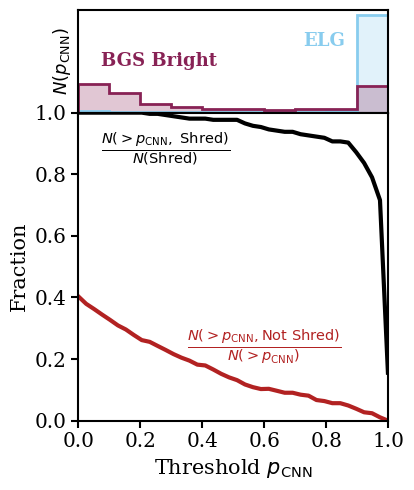

In [175]:

# Create the figure and gridspec
fig = plt.figure(figsize=(4, 4*4/3))
gs = fig.add_gridspec(2, 1, height_ratios=[1, 3], hspace=0.0)

# Top: histogram
ax_hist = fig.add_subplot(gs[0])

# Bottom: line plot
ax_plot = fig.add_subplot(gs[1], sharex=ax_hist)

# Plot histogram
ax_hist.hist(elg_cat["PCNN_FRAGMENT"], density=True,bins=np.arange(0,1.1,0.1), color=sample_color_map["ELG"], alpha=1,histtype="step",lw=2)
ax_hist.hist(elg_cat["PCNN_FRAGMENT"], density=True,bins=np.arange(0,1.1,0.1), color=sample_color_map["ELG"], alpha=0.25,histtype="stepfilled")


ax_hist.hist(bgsb_cat["PCNN_FRAGMENT"], density=True,bins=np.arange(0,1.1,0.1), color=sample_color_map["BGS_BRIGHT"], alpha=1,histtype="step",lw=2)
ax_hist.hist(bgsb_cat["PCNN_FRAGMENT"], density=True,bins=np.arange(0,1.1,0.1), color=sample_color_map["BGS_BRIGHT"], alpha=0.25,histtype="stepfilled",lw=2)

ax_hist.text(0.075,0.45, "BGS Bright", color=sample_color_map["BGS_BRIGHT"] ,  transform=ax_hist.transAxes,fontsize = 13,weight="bold" )
ax_hist.text(0.725,0.65, "ELG", color=sample_color_map["ELG"] ,  transform=ax_hist.transAxes,fontsize = 13,weight="bold" )

# ax_hist.set_ylabel('')
ax_hist.tick_params(labelbottom=False)  # Hide x labels on hist
ax_hist.set_yticks([])
# ax_hist.axvline(0.4, color = "k", ls = "--", lw = 1, alpha = 0.5)
ax_hist.set_ylabel(r"$N(p_{\rm CNN})$",fontsize = 13)

color_frag = "k"
color_good = "firebrick"

# Plot line
ax_plot.plot(thresh_grid, frag_comp,lw = 3,color = color_frag)
ax_plot.plot(thresh_grid, good_impure,lw = 3,color = color_good)

# ax_plot.set_xlabel('X')
# ax_plot.set_ylabel('Y')
ax_plot.set_xlim([0,1])
ax_plot.set_ylim([0,1])
ax_plot.set_xlabel(r"Threshold $p_{\rm CNN}$",fontsize = 15)

# ax_plot.axvline(0.5, color = "k", ls = "--", lw = 1,alpha = 0.4)

ax_plot.text(0.35,0.22,r"$\frac{N( > p_{\rm CNN}, \text{Not Shred}  ) }{N( > p_{\rm CNN}  )}$",fontsize = 15,
             color = color_good)

ax_plot.text(0.075,0.86,r"$\frac{N( > p_{\rm CNN}, \text{ Shred}  ) }{N( \text{Shred}  )}$",fontsize = 15,
             color = color_frag)

ax_plot.set_ylabel(r"Fraction",fontsize = 15)

plt.savefig("plots/pcnn_threshold.pdf",bbox_inches="tight")

plt.show()





In [43]:
bgsb_cat = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_photometry/iron_LOWZ_shreds_catalog_w_aper_mags.fits")


In [48]:
print( len(bgsb_cat[bgsb_cat["PCNN_FRAGMENT"].data < 0.5])/len(bgsb_cat) )

0.6255114663621658


In [49]:
print( len(bgsb_cat[(bgsb_cat["PCNN_FRAGMENT"].data < 0.5) & mask])/len(bgsb_cat[mask]) )

##ok! this fraction of galaxies with PCNN_FRAGMENT < 0.5 in BGS Bright is consistent with old data!

0.41540317022742934


In [40]:
# shred_cat = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/desi_y1_dwarf_shreds_catalog_v3.fits")
# # temp = shred_cat[shred_cat["SAMPLE"] == "BGS_FAINT"]
# # ##what fraction of these sou
# # print(np.sum(temp["PCNN_FRAGMENT"] < 0.5)/len(temp))

# # #3

In [ ]:
# temp = shred_cat[shred_cat["SAMPLE"] == "BGS_FAINT"]
# ##what fraction of these sou
# print(np.sum(temp["PCNN_FRAGMENT"] < 0.5)/len(temp))

# #3

In [51]:
bgsb_cat = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_photometry/iron_BGS_BRIGHT_shreds_catalog_w_aper_mags.fits")
shred_mask = (bgsb_cat["FRACFLUX_G"] > 0.2) & (bgsb_cat["FRACFLUX_R"] > 0.2) & (bgsb_cat["FRACFLUX_Z"] > 0.2)

In [4]:
np.sum(shred_cat["PCNN_FRAGMENT"] < 0.5)/len(shred_cat)

1.0

In [ ]:
21258, 36072

In [129]:
## make a visual of examples of PCNN < 0.5 and PCNN > 0.5 objects

def get_plotting_inds(main_cat):
    '''
    Function that randomly selects rows from a given galaxy sample in a catalo
    '''

    # Get unique samples
    samples = ['BGS_BRIGHT', 'BGS_FAINT', 'LOWZ', 'ELG'][::-1]
    
    # Dictionary to hold random indices
    random_indices = []
    
    for samp in samples:
        # Find the row indices where sample matches
        mask = main_cat['SAMPLE'] == samp
        matching_indices = np.where(mask)[0]
        # Randomly pick one index
        rand_idx = np.random.choice(matching_indices)
        random_indices.append(rand_idx)
    
    print(random_indices)

    return np.array(random_indices)


def make_img_s_pcnn_panels():
    '''
    This function makes the pCNN IMG and IMG-S panel image
    '''
    
    #this is the entire shredded catalog that also includes PCNN_FRAGMENT COLUMN
    data_main = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/desi_y1_dwarf_shreds_catalog_v4.fits")

    print(len(data_main))
    
    data_cnn_shred = data_main[data_main["PCNN_FRAGMENT"] >= 0.5]
    data_cnn_clean = data_main[data_main["PCNN_FRAGMENT"] < 0.5]

    print(len(data_cnn_clean))
    
    #choosing the random plot inds
    #hard coding them to keep them stable now
    # clean_inds = get_plotting_inds(data_cnn_clean) #[8401, 12756, 5559, 2018] #
    # shred_inds = get_plotting_inds(data_cnn_shred) #[21258, 36072, 9603, 654] #

    clean_inds = [8401, 12756, 5559, 2018] 
    shred_inds = [21258, 36072, 9603, 654] 
    
    print(clean_inds)
    print(shred_inds)
    
    ### making the fragment source panels
    fig, ax = make_subplots(ncol =2, nrow = 4, col_spacing = 0.05, row_spacing = 0.35,plot_size = 2, return_fig=True )
        
    fig.text(0.175, 0.425, r'$p_{\rm CNN} \geq 0.5$', ha='center', va='top', fontsize=20)
    
    ax[6].set_title(r"IMG",fontsize = 18)
    ax[7].set_title(r"IMG - S",fontsize = 18)
    
    shred_tgids = data_cnn_shred[shred_inds]["TARGETID"].data
    
    for j in range(4):
        temp = np.load(f"/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/shred_classifier_output/shred_classifier_input_images/image_{shred_tgids[j]}.npy")
        #we crop to the center 64
        size = 64
        start = (96 - size) // 2
        end = start + size
        temp = temp[:, start:end, start:end]
        #make the rgb image!
        rgb1 = temp[:3]
        #make the sdss rgb image of this!
        rgb1 = sdss_rgb([rgb1[0],rgb1[1],rgb1[2]], ["g","r","z"], scales=dict(g=(2,6.0), r=(1,3.4), z=(0,2.2)), m=0.03)
        rgb2 = temp[3:6]
        rgb2 = sdss_rgb([rgb2[0],rgb2[1],rgb2[2]], ["g","r","z"], scales=dict(g=(2,6.0), r=(1,3.4), z=(0,2.2)), m=0.03)
        ax[2*j].imshow(rgb1)
        ax[2*j+1].imshow(rgb2)
        # ax[2*j].scatter( 32, 32,facecolor="none",edgecolor = "r",lw =1,s=400, ls = "--" )
        # ax[2*j+1].scatter( 32, 32,facecolor="none",edgecolor = "r",lw =1,s=400, ls = "--" )  

        for k in range(2):
            # Center in pixel coordinates
            center_x, center_y = 32, 32
            radius_in_pixels = (1.5/2)/0.262 #radius of DESI fiber diameter
            
            # Create and add the circle
            circ = Circle((center_x, center_y), radius_in_pixels,
                          facecolor='none', edgecolor='lime', lw=1.5, ls='--')
            ax[2*j+k].add_patch(circ)
        
    for axi in ax:
        axi.set_yticks([])
        axi.set_xticks([])

    ax[6].text(0.5,0.9,"BGS Bright",fontsize = 12,color = "white",ha="center",va="center",
              transform  = ax[6].transAxes,weight="bold")

    ax[4].text(0.5,0.9,"BGS Faint",fontsize = 12,color = "white",ha="center",va="center",
              transform  = ax[4].transAxes,weight="bold")

    ax[2].text(0.5,0.9,"LOWZ",fontsize = 12,color = "white",ha="center",va="center",
              transform  = ax[2].transAxes,weight="bold")

    ax[0].text(0.5,0.9,"ELG",fontsize = 12,color = "white",ha="center",va="center",
              transform  = ax[0].transAxes,weight="bold")
    
    plt.savefig("plots/shred_egs_pcnn.png",dpi=300,bbox_inches="tight")
    plt.show()

    ##making the clean source panels

    fig, ax = make_subplots(ncol =2, nrow = 4, col_spacing = 0.05, row_spacing = 0.35,plot_size = 2, return_fig=True )
    fig.text(0.175, 0.425, r'$p_{\rm CNN} < 0.5$', ha='center', va='top', fontsize=20)
    
    ax[6].set_title(r"IMG",fontsize = 18)
    ax[7].set_title(r"IMG - S",fontsize = 18)

    clean_tgids = data_cnn_clean[clean_inds]["TARGETID"].data

    for j in range(4):
        temp = np.load(f"/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/shred_classifier_output/shred_classifier_input_images/image_{clean_tgids[j]}.npy")
    
        #we crop to the center 64
        size = 64
        start = (96 - size) // 2
        end = start + size
        temp = temp[:, start:end, start:end]
    
        #make the rgb image!
        rgb1 = temp[:3]
        #make the sdss rgb image of this!
        rgb1 = sdss_rgb([rgb1[0],rgb1[1],rgb1[2]], ["g","r","z"], scales=dict(g=(2,6.0), r=(1,3.4), z=(0,2.2)), m=0.03)
     
        rgb2 = temp[3:6]
        rgb2 = sdss_rgb([rgb2[0],rgb2[1],rgb2[2]], ["g","r","z"], scales=dict(g=(2,6.0), r=(1,3.4), z=(0,2.2)), m=0.03)
    
        ax[2*j].imshow(rgb1)
        ax[2*j+1].imshow(rgb2)
        
        # ax[2*j].scatter( 32, 32,facecolor="none",edgecolor = "r",lw =1,s=400, ls = "--" )
        # ax[2*j+1].scatter( 32, 32,facecolor="none",edgecolor = "r",lw =1,s=400, ls = "--" )

        for k in range(2):
            # Center in pixel coordinates
            center_x, center_y = 32, 32
            radius_in_pixels = (1.5/2)/0.262 #radius of DESI fiber diameter
            
            # Create and add the circle
            circ = Circle((center_x, center_y), radius_in_pixels,
                          facecolor='none', edgecolor='lime', lw=1.5, ls='--')
            ax[2*j+k].add_patch(circ)

            
    for axi in ax:
        axi.set_yticks([])
        axi.set_xticks([])

    
    ax[6].text(0.5,0.9,"BGS Bright",fontsize = 12,color = "white",ha="center",va="center",
              transform  = ax[6].transAxes,weight="bold")

    ax[4].text(0.5,0.9,"BGS Faint",fontsize = 12,color = "white",ha="center",va="center",
              transform  = ax[4].transAxes,weight="bold")

    ax[2].text(0.5,0.9,"LOWZ",fontsize = 12,color = "white",ha="center",va="center",
              transform  = ax[2].transAxes,weight="bold")

    ax[0].text(0.5,0.9,"ELG",fontsize = 12,color = "white",ha="center",va="center",
              transform  = ax[0].transAxes,weight="bold")
    
        
    plt.savefig("plots/TEMP_clean_egs_pcnn.png",dpi=300,bbox_inches="tight")
    plt.show()

    return



49060
12897
[8401, 12756, 5559, 2018]
[21258, 36072, 9603, 654]


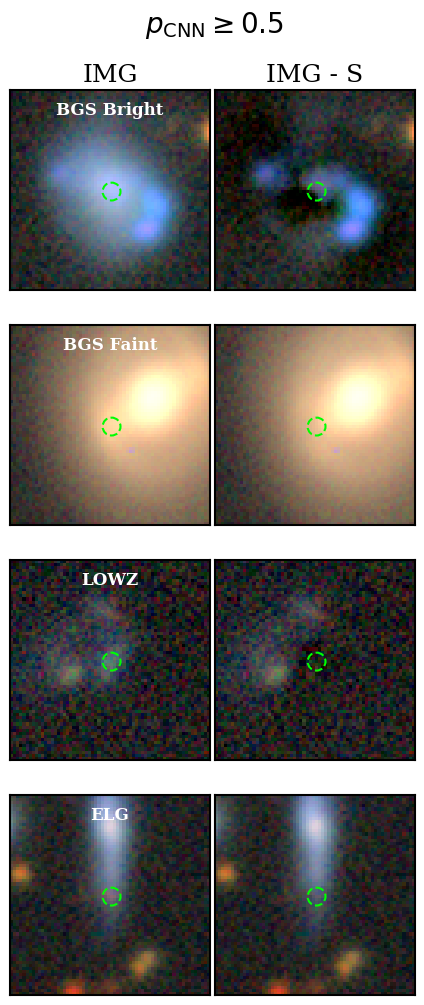

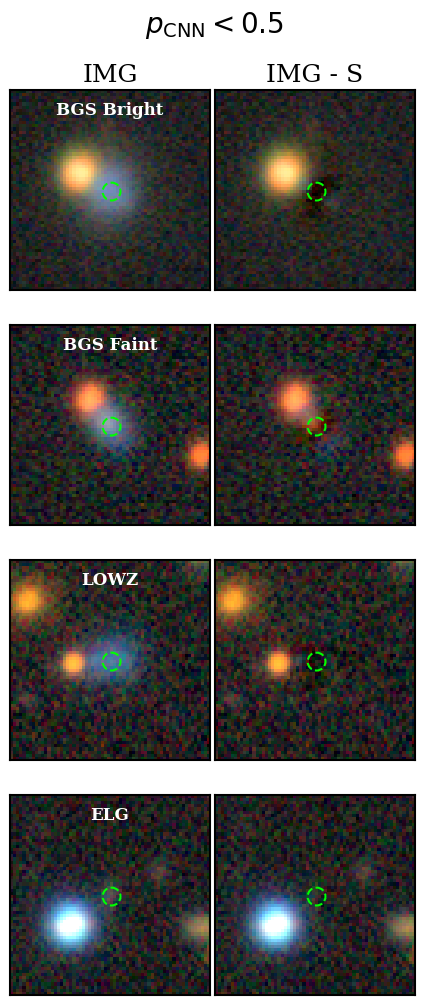

In [130]:
make_img_s_pcnn_panels()

## Make delta mag distributions as a function of PCNN split

In [128]:
from consolidate_photometry import consolidate_new_photo, consolidate_positions_and_shapes, consolidate_cog_photo
from shred_photometry_maskbits import create_shred_maskbits_from_dict

def do_consolidate(cat,sample, only_cog=True):
    '''
    Here we consolidate the photo

    if only_cog=True, we only consolidate the cog photometries and do not bother with the tractor based ones.
    if false, then we find consolidate over all those different photometries
    '''

    ##do not do any consolidation, we will be using the COG mag here, but just need to identify when it is best!!

    if only_cog:
        cat = consolidate_cog_photo(cat,sample=sample, add_pcnn=True)

        #and for this case the COG_MAG_X_FINAL is the best one so we will copy it to this to avoid any bugs in the popeline

        cat["MAG_G_BEST"] = cat["COG_MAG_G_FINAL"].data.copy()
        cat["MAG_R_BEST"] = cat["COG_MAG_R_FINAL"].data.copy()
        cat["MAG_Z_BEST"] = cat["COG_MAG_Z_FINAL"].data.copy()
        
        #add maskbits to find when cog is reliable!
        bitmasks_list = [0,1,2,3,4,5,6,7,8,9,10,12]
    
        print("Adding the COG photo maskbits")
        photo_maskbits =  create_shred_maskbits_from_dict(cat, bitmasks_to_apply = bitmasks_list, verbose=True)
        cat["PHOTO_MASKBIT"] = photo_maskbits

        #identifying the robust ones!
        cat = cat[cat["PHOTO_MASKBIT"] == 0]

    else:
        #finding hte best over all the different kinds! However, we still do not use PCNN as we are trying to show how 
        #good our CNN is and also check photometry at the same time
        #in the actual consolidation, we will use CNN information in consolidation
        cat = consolidate_new_photo(cat,sample=sample, use_pcnn=False)

        cat = cat[cat["PHOTO_MASKBIT"] == 0]
    
    return cat

In [129]:
## load the catalogs!

bgsb_cat = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_photometry/iron_BGS_BRIGHT_shreds_catalog_w_aper_mags.fits")
bgsf_cat = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_photometry/iron_BGS_FAINT_shreds_catalog_w_aper_mags.fits")
lowz_cat = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_photometry/iron_LOWZ_shreds_catalog_w_aper_mags.fits")
elg_cat = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_photometry/iron_ELG_shreds_catalog_w_aper_mags.fits")

#get the consolidate photometry!!
bgsb_cat_only_cog = do_consolidate(bgsb_cat.copy(),sample="BGS_BRIGHT", only_cog=True)
bgsf_cat_only_cog = do_consolidate(bgsf_cat.copy(),sample="BGS_FAINT", only_cog=True)
lowz_cat_only_cog = do_consolidate(lowz_cat.copy(),sample="LOWZ", only_cog=True)
elg_cat_only_cog = do_consolidate(elg_cat.copy(),sample="ELG", only_cog=True)

# #get the consolidate photometry!!
# bgsb_cat_best = do_consolidate(bgsb_cat,sample="BGS_BRIGHT", only_cog=False)
# bgsf_cat_best = do_consolidate(bgsf_cat,sample="BGS_FAINT", only_cog=False)
# lowz_cat_best = do_consolidate(lowz_cat,sample="LOWZ", only_cog=False)
# elg_cat_best = do_consolidate(elg_cat,sample="ELG", only_cog=False)


Need to rerun the shred catalog after having fixed the column name
Added PCNN values!
Adding the COG photo maskbits
MASKBIT=2^0, cog nan mask, 0.0031
MASKBIT=2^1, cog not converge, fraction: 0.059806
MASKBIT=2^2, bad resid, fraction : 0.0070
MASKBIT=2^3, cog curve decrease, fraction: 0.0124
MASKBIT=2^4, aperfrac-in image, fraction: 0.001570
MASKBIT=2^5, aperfrac-mask image, fraction: 0.047340
MASKBIT=2^6, image-frac mask, fraction: 0.000809
MASKBIT=2^7, bad colors, fraction: 0.003473
MASKBIT=2^8, source not on segment, fraction: 0.0000
MASKBIT=2^9, within star mask radius and not just a simple blend, fraction: 0.102151
MASKBIT=2^10, aper-cen masked, fraction: 0.049339
MASKBIT=2^12, near sga outskirts, fraction: 0.013798
Need to rerun the shred catalog after having fixed the column name
Added PCNN values!
Adding the COG photo maskbits
MASKBIT=2^0, cog nan mask, 0.0096
MASKBIT=2^1, cog not converge, fraction: 0.084634
MASKBIT=2^2, bad resid, fraction : 0.0117
MASKBIT=2^3, cog curve decre

In [130]:
def get_pcnn_dists(shred_cat):
    '''
    Function that computes the array of mag diffs and pcnn values for different samples!
    '''
    bgsb_cat = shred_cat[shred_cat["PHOTO_MASKBIT"] == 0]
    
    bgsb_cat["DELTA_MAG_G"] =  bgsb_cat[f"MAG_G_BEST"] - bgsb_cat["MAG_G"]
    bgsb_cat["DELTA_MAG_R"] =  bgsb_cat[f"MAG_R_BEST"] - bgsb_cat["MAG_R"]
    bgsb_cat["DELTA_MAG_Z"] =  bgsb_cat[f"MAG_Z_BEST"] - bgsb_cat["MAG_Z"]

    # bgsb_cat["DELTA_MAG_G"] =  bgsb_cat[f"COG_MAG_G_FINAL"] - bgsb_cat["MAG_G"]
    # bgsb_cat["DELTA_MAG_R"] =  bgsb_cat[f"COG_MAG_R_FINAL"] - bgsb_cat["MAG_R"]
    # bgsb_cat["DELTA_MAG_Z"] =  bgsb_cat[f"COG_MAG_Z_FINAL"] - bgsb_cat["MAG_Z"]

    tot_delts = np.concatenate( [bgsb_cat["DELTA_MAG_G"].data, bgsb_cat["DELTA_MAG_R"].data, bgsb_cat["DELTA_MAG_Z"].data] ) 

    tot_pcnn = np.concatenate( [bgsb_cat["PCNN_FRAGMENT"].data, bgsb_cat["PCNN_FRAGMENT"].data, bgsb_cat["PCNN_FRAGMENT"].data] ) 
    
    return tot_delts, tot_pcnn


In [138]:
delts_bgsb_only_cog, pcnn_bgsb_only_cog = get_pcnn_dists(bgsb_cat_only_cog)
delts_bgsf_only_cog, pcnn_bgsf_only_cog = get_pcnn_dists(bgsf_cat_only_cog)
# delts_lowz_only_cog, pcnn_lowz_only_cog = get_pcnn_dists(lowz_cat_only_cog)
# delts_elg_only_cog, pcnn_elg_only_cog = get_pcnn_dists(elg_cat_only_cog)

delts_bgsb_best, pcnn_bgsb_best = get_pcnn_dists(bgsb_cat_best)
delts_bgsf_best, pcnn_bgsf_best = get_pcnn_dists(bgsf_cat_best)
# delts_lowz_best, pcnn_lowz_best = get_pcnn_dists(lowz_cat_best)
# delts_elg_best, pcnn_elg_best = get_pcnn_dists(elg_cat_best)


In [139]:
from scipy import stats

def make_single_panel(ax, delts, pcnn,density=False):

    mask_high = pcnn >= pcnn_cut
    mask_low  = pcnn < pcnn_cut

    ax.hist( delts, range = (-7,2),bins=bins,histtype = "stepfilled",color = "grey",
            alpha = tot_alpha,lw = lw, label = r"Total",density=density)

    ax.hist(delts[mask_high], range=(-7, 2), bins=bins, histtype="step",
           lw=lw, color="mediumblue", label=r"$p_{\rm CNN} \geq 0.5$",density=density)

    ax.hist(delts[mask_low], range=(-7, 2), bins=bins, histtype="step",
               lw=lw, color="firebrick", label=r"$p_{\rm CNN} < 0.5$",density=density)

    return



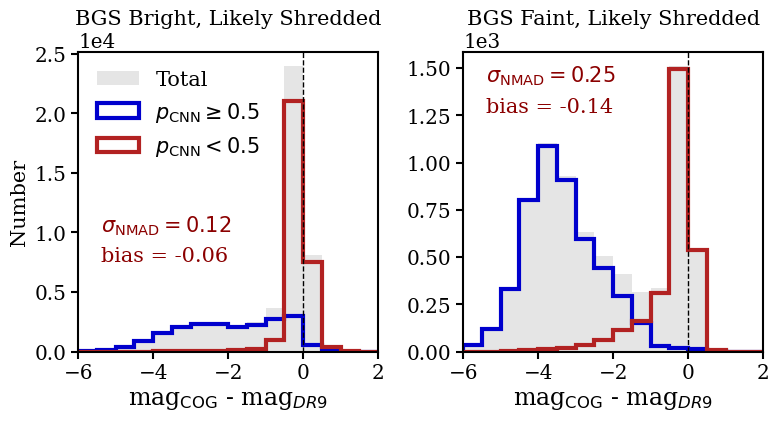

In [147]:
fig,ax = make_subplots(ncol=2,nrow = 1, return_fig=True,col_spacing=0.85)

pcnn_cut = 0.5
bins = np.arange(-6.5,2.5,0.5)
lw = 3
tot_alpha = 0.2

fs = 17
fs_2 = 15

ax[0].set_title(r"BGS Bright, Likely Shredded",fontsize = fs_2)
make_single_panel(ax[0], delts_bgsb_only_cog, pcnn_bgsb_only_cog, density=False)

ax[1].set_title(r"BGS Faint, Likely Shredded",fontsize = fs_2)
make_single_panel(ax[1], delts_bgsf_only_cog, pcnn_bgsf_only_cog, density=False)

vals = delts_bgsb_only_cog[pcnn_bgsb_only_cog < pcnn_cut]
vals = vals[~np.isnan(vals)]
ax[0].text(0.075,0.4, rf"$\sigma_{{\rm NMAD}} = {stats.median_abs_deviation(vals, scale='normal'):.2f}$",
           fontsize = 15, transform = ax[0].transAxes,color = "darkred")
ax[0].text(0.075,0.3, f"bias = {np.median(vals):.2f}",
           fontsize = 15, transform = ax[0].transAxes,color = "darkred")

vals = delts_bgsf_only_cog[pcnn_bgsf_only_cog < pcnn_cut]
vals = vals[~np.isnan(vals)]
ax[1].text(0.075,0.9, rf"$\sigma_{{\rm NMAD}} = {stats.median_abs_deviation(vals, scale='normal'):.2f}$",
           fontsize = 15, transform = ax[1].transAxes,color = "darkred")
ax[1].text(0.075,0.8, f"bias = {np.median(vals):.2f}",
           fontsize = 15, transform = ax[1].transAxes,color = "darkred")

for i in range(2):
    ax[0].legend(frameon=False,loc="upper left",fontsize=15)
    ax[i].set_xlim([-6,2])
    ax[i].set_xlabel(r"mag$_{\rm COG}$ - mag$_{DR9}$",fontsize = fs)
    ax[i].axvline(x = 0,color = "k",ls = "--",lw = 1)
    ax[0].set_ylabel("Number",fontsize = 15)
    ax[i].ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    
    
plt.savefig("plots/pcnn_delta_mag_dist.pdf",bbox_inches="tight")
    
plt.show()

In [134]:
# fig,ax = make_subplots(ncol=4,nrow = 1, return_fig=True,col_spacing=0.85)

# pcnn_cut = 0.5
# bins = np.arange(-6.5,2.5,0.5)
# lw = 3
# tot_alpha = 0.2

# fs = 17

# fs_2 = 15

# #####
# ## TOP ROW FOR JUST COG
# ####

# ax[0].set_title(r"BGS Bright, Likely Shredded",fontsize = fs_2)
# make_single_panel(ax[0], delts_bgsb_only_cog, pcnn_bgsb_only_cog, density=False)

# ax[1].set_title(r"BGS Faint, Likely Shredded",fontsize = fs_2)
# make_single_panel(ax[1], delts_bgsf_only_cog, pcnn_bgsf_only_cog, density=False)

# ax[2].set_title(r"LOWZ, Likely Shredded",fontsize = fs_2)
# make_single_panel(ax[2], delts_lowz_only_cog, pcnn_lowz_only_cog, density=False)

# ax[3].set_title(r"ELG, Likely Shredded",fontsize = fs_2)
# make_single_panel(ax[3], delts_elg_only_cog, pcnn_elg_only_cog, density=False)

# vals = delts_bgsb_only_cog[pcnn_bgsb_only_cog < pcnn_cut]
# vals = vals[~np.isnan(vals)]
# ax[0].text(0.075,0.4, rf"$\sigma_{{\rm NMAD}} = {stats.median_abs_deviation(vals, scale='normal'):.2f}$",
#            fontsize = 15, transform = ax[0].transAxes,color = "darkred")
# ax[0].text(0.075,0.3, f"bias = {np.median(vals):.2f}",
#            fontsize = 15, transform = ax[0].transAxes,color = "darkred")

# vals = delts_bgsf_only_cog[pcnn_bgsf_only_cog < pcnn_cut]
# vals = vals[~np.isnan(vals)]
# ax[1].text(0.075,0.9, rf"$\sigma_{{\rm NMAD}} = {stats.median_abs_deviation(vals, scale='normal'):.2f}$",
#            fontsize = 15, transform = ax[1].transAxes,color = "darkred")
# ax[1].text(0.075,0.8, f"bias = {np.median(vals):.2f}",
#            fontsize = 15, transform = ax[1].transAxes,color = "darkred")

# for i in range(4):
#     ax[0].legend(frameon=False,loc="upper left",fontsize=15)
#     ax[i].set_xlim([-6,2])
#     ax[i].set_xlabel(r"mag$_{\rm COG}$ - mag$_{DR9}$",fontsize = fs)
#     ax[i].axvline(x = 0,color = "k",ls = "--",lw = 1)


# #####
# ## BOTTOM ROW FOR BEST 
# ####

# # make_single_panel(ax[0], delts_bgsb_best, pcnn_bgsb_best, density=False)

# # make_single_panel(ax[1], delts_bgsf_best, pcnn_bgsf_best, density=False)

# # make_single_panel(ax[2], delts_lowz_best, pcnn_lowz_best, density=False)

# # make_single_panel(ax[3], delts_elg_best, pcnn_elg_best, density=False)

# # # vals = delts_bgsb[pcnn_bgsb < pcnn_cut]
# # # vals = vals[~np.isnan(vals)]
# # # ax[4].text(0.075,0.4, rf"$\sigma_{{\rm NMAD}} = {stats.median_abs_deviation(vals, scale='normal'):.2f}$",
# # #            fontsize = 15, transform = ax[0].transAxes,color = "darkred")
# # # ax[4].text(0.075,0.3, f"bias = {np.median(vals):.2f}",
# # #            fontsize = 15, transform = ax[0].transAxes,color = "darkred")


# # # vals = delts_bgsf[pcnn_bgsf < pcnn_cut]
# # # vals = vals[~np.isnan(vals)]
# # # ax[5].text(0.075,0.9, rf"$\sigma_{{\rm NMAD}} = {stats.median_abs_deviation(vals, scale='normal'):.2f}$",
# # #            fontsize = 15, transform = ax[1].transAxes,color = "darkred")
# # # ax[5].text(0.075,0.8, f"bias = {np.median(vals):.2f}",
# # #            fontsize = 15, transform = ax[1].transAxes,color = "darkred")


# # for i in range(4):
# #     ax[i].set_xlim([-6,2])
# #     ax[i].set_xlabel(r"mag$_{\rm Best}$ - mag$_{DR9}$",fontsize = fs)
# #     ax[i].axvline(x = 0,color = "k",ls = "--",lw = 1)


# # ax[0].set_ylim([0,25000])
# # ax[4].set_ylim([0,25000])

# # ax[1].set_ylim([0,2700])
# # ax[5].set_ylim([0,2700])

# ##add the sigma and bias params ... 

# # vals = delts_lowz[pcnn_lowz < pcnn_cut]
# # vals = vals[~np.isnan(vals)]
# # ax[2].text(0.075,0.9, rf"$\sigma_{{\rm NMAD}} = {stats.median_abs_deviation(vals, scale='normal'):.2f}$",
# #            fontsize = 15, transform = ax[2].transAxes,color = "darkred")
# # ax[2].text(0.075,0.8, f"bias = {np.median(vals):.2f}",
# #            fontsize = 15, transform = ax[2].transAxes,color = "darkred")

# # vals = delts_elg[pcnn_elg < pcnn_cut]
# # vals = vals[~np.isnan(vals)]
# # ax[3].text(0.5,0.9, rf"$\sigma_{{\rm NMAD}} = {stats.median_abs_deviation(vals, scale='normal'):.2f}$",
# #            fontsize = 15, transform = ax[3].transAxes,color = "darkred")
# # ax[3].text(0.5,0.8, f"bias = {np.median(vals):.2f}",
# #            fontsize = 15, transform = ax[3].transAxes,color = "darkred")

# # plt.savefig("plots/pcnn_delta_mag_dist.pdf",bbox_inches="tight")
    
# plt.show()

## Compare COG mag with tractor based and tractor brightest

In [27]:
from consolidate_photometry import consolidate_new_photo, consolidate_positions_and_shapes, consolidate_cog_photo
from shred_photometry_maskbits import create_shred_maskbits_from_dict

def do_consolidate(cat,sample):
    '''
    Here we consolidate the photo

    if only_cog=True, we only consolidate the cog photometries and do not bother with the tractor based ones.
    if false, then we find consolidate over all those different photometries
    '''

    ##do not do any consolidation, we will be using the COG mag here, but just need to identify when it is best!!

    cat = consolidate_cog_photo(cat,sample=sample, add_pcnn=True)

    cat["MAG_G_BEST"] = cat["COG_MAG_G_FINAL"].data.copy()
    cat["MAG_R_BEST"] = cat["COG_MAG_R_FINAL"].data.copy()
    cat["MAG_Z_BEST"] = cat["COG_MAG_Z_FINAL"].data.copy()
    #and for this case the COG_MAG_X_FINAL is the best one so we will copy it to this to avoid any bugs in the popeline

    #we want to only select the objects where COG is preffered?
    
    #add maskbits to find when cog is reliable!
    bitmasks_list = [0,1,2,3,4,5,6,7,8,9,10,12]

    print("Adding the COG photo maskbits")
    photo_maskbits =  create_shred_maskbits_from_dict(cat, bitmasks_to_apply = bitmasks_list, verbose=True)
    cat["PHOTO_MASKBIT"] = photo_maskbits

    #identifying the robust ones!
    cat = cat[cat["PHOTO_MASKBIT"] == 0]

    return cat

In [28]:
bgsb_cat = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_photometry/iron_BGS_BRIGHT_shreds_catalog_w_aper_mags.fits")
bgsf_cat = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_photometry/iron_BGS_FAINT_shreds_catalog_w_aper_mags.fits")
lowz_cat = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_photometry/iron_LOWZ_shreds_catalog_w_aper_mags.fits")
elg_cat = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_photometry/iron_ELG_shreds_catalog_w_aper_mags.fits")

#get the consolidate photometry!!
bgsb_cat = do_consolidate(bgsb_cat.copy(),sample="BGS_BRIGHT")
bgsf_cat = do_consolidate(bgsf_cat.copy(),sample="BGS_FAINT")
lowz_cat = do_consolidate(lowz_cat.copy(),sample="LOWZ")
elg_cat = do_consolidate(elg_cat.copy(),sample="ELG")

Added PCNN values!
Adding the COG photo maskbits
MASKBIT=2^0, cog nan mask, 0.0031
MASKBIT=2^1, cog not converge, fraction: 0.058949
MASKBIT=2^2, bad resid, fraction : 0.0056
MASKBIT=2^3, cog curve decrease, fraction: 0.0096
MASKBIT=2^4, aperfrac-in image, fraction: 0.001047
MASKBIT=2^5, aperfrac-mask image, fraction: 0.047007
MASKBIT=2^6, image-frac mask, fraction: 0.000809
MASKBIT=2^7, bad colors, fraction: 0.002522
MASKBIT=2^8, source not on segment, fraction: 0.0000
MASKBIT=2^9, within star mask radius and not just a simple blend, fraction: 0.102151
MASKBIT=2^10, aper-cen masked, fraction: 0.048958
MASKBIT=2^12, bad rchisq, fraction: 0.131221
Added PCNN values!
Adding the COG photo maskbits
MASKBIT=2^0, cog nan mask, 0.0096
MASKBIT=2^1, cog not converge, fraction: 0.082233
MASKBIT=2^2, bad resid, fraction : 0.0114
MASKBIT=2^3, cog curve decrease, fraction: 0.0066
MASKBIT=2^4, aperfrac-in image, fraction: 0.000300
MASKBIT=2^5, aperfrac-mask image, fraction: 0.124850
MASKBIT=2^6, ima

In [29]:
sample_color_map = {"BGS_BRIGHT" : "#882255", "BGS_FAINT": "#CC6677", "LOWZ":"#DDCC77", "ELG": "#88CCEE" }

import colorsys
import matplotlib.colors as mcolors


def related_contrast_color(hex_color, lighten=True, factor=0.4):
    # Convert HEX → RGB → HSV
    rgb = mcolors.to_rgb(hex_color)
    h, s, v = colorsys.rgb_to_hsv(*rgb)
    
    # Adjust brightness (v) or saturation
    if lighten:
        v = min(1, v + factor * (1 - v))
        s = max(0, s - 0.2)  # slightly desaturate
    else:
        v = max(0, v * (1 - factor))
        s = min(1, s + 0.2)
    
    # Back to HEX
    new_rgb = colorsys.hsv_to_rgb(h, s, v)
    return mcolors.to_hex(new_rgb)

In [30]:
def make_single_hist(ax, cat, color, lighten=False):

    #combine Grz

    cog_mags = np.concatenate( [ cat["COG_MAG_G_FINAL"].data,  cat["COG_MAG_R_FINAL"].data,  cat["COG_MAG_Z_FINAL"].data  ] )

    tractor_based_mags = np.concatenate( [ cat["TRACTOR_ONLY_MAG_G_FINAL"].data,  cat["TRACTOR_ONLY_MAG_R_FINAL"].data,  cat["TRACTOR_ONLY_MAG_Z_FINAL"].data  ] )

    tractor_bright_mags = np.concatenate( [ cat["TRACTOR_BRIGHTEST_SOURCE_MAGS_FINAL"].data[:,0], cat["TRACTOR_BRIGHTEST_SOURCE_MAGS_FINAL"].data[:,1], cat["TRACTOR_BRIGHTEST_SOURCE_MAGS_FINAL"].data[:,2]  ] )

    delta_based = cog_mags - tractor_based_mags
    delta_bright = cog_mags - tractor_bright_mags


    color_new = related_contrast_color(color, lighten=lighten, factor=0.4)

    ax.hist(delta_bright, range=(-1.5,1.5), bins = np.arange(-1.5,1.5,0.1), density=True, label = r"X=TRACTOR_BRIGHTEST",histtype="step",lw=2, color = color_new,ls="--")    

    ax.hist(delta_based, range=(-1.5,1.5), bins = np.arange(-1.5,1.5,0.1), density=True, label = r"X=TRACTOR_BASED",histtype="stepfilled",lw=2, color = color )

    return ax,  cat["COG_MAG_R_FINAL"].data - cat["TRACTOR_ONLY_MAG_R_FINAL"].data
    

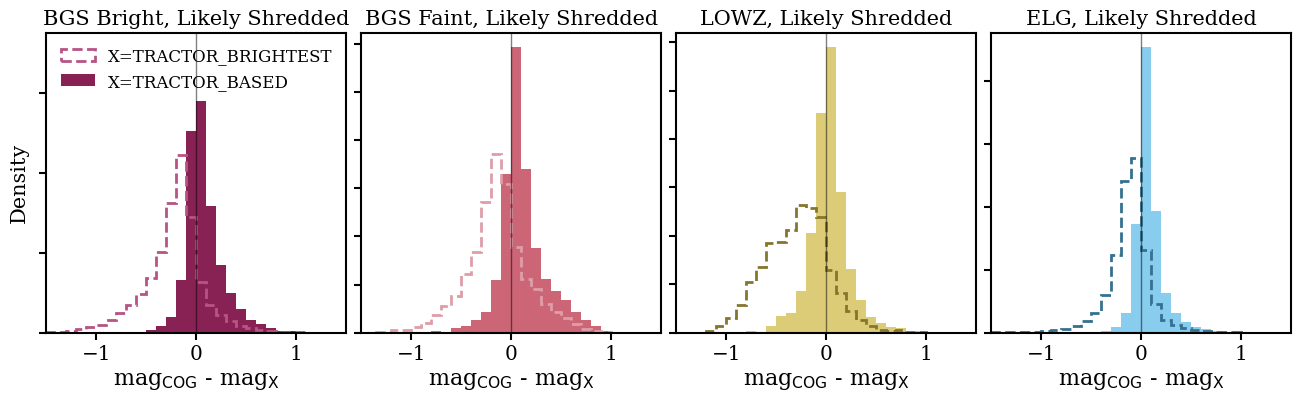

In [31]:
fig,ax = make_subplots(ncol=4,nrow = 1, return_fig=True,col_spacing=0.15)


_,bgsb_delta_based = make_single_hist(ax[0], bgsb_cat, color = sample_color_map["BGS_BRIGHT"], lighten=True )
_,_=make_single_hist(ax[1], bgsf_cat, color = sample_color_map["BGS_FAINT"], lighten=True )
_,_=make_single_hist(ax[2], lowz_cat, color = sample_color_map["LOWZ"], lighten=False )
_,_=make_single_hist(ax[3], elg_cat, color = sample_color_map["ELG"], lighten=False )


ax[0].legend(frameon=False,loc="upper left",fontsize = 12)

for axi in ax:
    ax[0].set_ylim([0,3.75])
    axi.set_xlim([-1.5,1.5])
    axi.set_yticklabels([])
    axi.set_xlabel(r"mag$_{\rm COG}$ - mag$_{\rm X}$",fontsize = 16)
    axi.axvline(x = 0,color = "k",ls = "-",lw = 1,alpha=0.5)
    ax[0].set_ylabel("Density",fontsize = 15)

ax[0].set_title("BGS Bright, Likely Shredded",fontsize = 15)
ax[1].set_title("BGS Faint, Likely Shredded",fontsize = 15)
ax[2].set_title("LOWZ, Likely Shredded",fontsize = 15)
ax[3].set_title("ELG, Likely Shredded",fontsize = 15)
    

# plt.savefig("plots/cog_compare_tractor_based.pdf",bbox_inches="tight")

plt.show()

In [11]:
bgsf_cat[ bgsf_cat["COG_MAG_R_FINAL"].data -  bgsf_cat["TRACTOR_ONLY_MAG_R_FINAL"].data > 0.75]["FILE_PATH"]

# 39627720748961105

/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-040m015-050m010/0458m135/BGS_FAINT_tgid_39627462136564590
/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-130m010-140m005/1378m075/BGS_FAINT_tgid_39627606240266590
/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-180m010-190m005/1846m072/BGS_FAINT_tgid_39627613018262613
/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-310m010-320m005/3190m072/BGS_FAINT_tgid_39627615258023659
/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-060m005-070p000/0673m045/BGS_FAINT_tgid_39627677195310193
/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-170m005-180p000/1701m040/BGS_FAINT_tgid_39627690973598691
/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-030m005-040p000/0376m027/BGS_FAINT_tgid_39627718920242372
/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-140m005-150p000/1466m027/BGS_FAINT_tgid_39627720748961105
/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-220m005-230p000/2256m025/BGS_FAINT_tgid_39627728114157016
/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-220m005-230p000/2256m025/BGS_FAINT_tgid_39627728114157066
/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-140p000-150p005/1420p047/BGS_FAINT_tgid_39627901800286778


In [281]:
# 39633536503778830
